In [1]:
import sys
sys.path

['C:\\Users\\DELL\\OneDrive - EDU A1\\git-code\\github\\CHILI-ETC\\REF\\REF-jvmt\\code',
 'C:\\Users\\DELL\\Anaconda3\\python37.zip',
 'C:\\Users\\DELL\\Anaconda3\\DLLs',
 'C:\\Users\\DELL\\Anaconda3\\lib',
 'C:\\Users\\DELL\\Anaconda3',
 '',
 'C:\\Users\\DELL\\AppData\\Roaming\\Python\\Python37\\site-packages',
 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages',
 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\aia_mkmovie-0.1.0-py3.7.egg',
 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\pytz-2022.1-py3.7.egg',
 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\DELL\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\DELL\\.ipython']

In [2]:
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from sympy import *
import os
from scipy.integrate import simps
import sys
#sys.path.append('../code/')


# test

In [3]:
def filteraa(filtera):
    #load the filters          
    filtersel=filtera #'../sdss_g0.par'            
    filterpath='./'
    filterfile=filterpath+filtersel   # ;fluxfilter: max=1, min=0, no particular unit
    print(filterfile)   

    ia=0
    with open(filterfile,'r') as fh:
        for line in fh:
            if line.startswith('#'):
                ia=ia+1
                continue

    band=pd.read_csv(filterfile,sep='\s+',header=None,skiprows=ia)
    wavefilter=np.array(band[0])
    fluxfilter=np.array(band[1])
    wavefilter=wavefilter  # A
    vmin=wavefilter[0]
    vmax=wavefilter[-1]

    # find the central wavelength, effective wavelength, and FWHM of the given filter
    filtermid=(vmax-vmin)*0.5  #A, central wavelength
    dwave=wavefilter[1:]-wavefilter[:-1]
    filtereff=np.nansum(dwave*wavefilter[1:]*fluxfilter[1:])/np.nansum(dwave*fluxfilter[1:]) #A, effective wavelength
    rmax=np.max(fluxfilter)
    nnn=np.where(fluxfilter > 0.5*rmax)[0]
    FWHMmin=wavefilter[nnn[0]]
    FWHMmax=wavefilter[nnn[-1]]
    filterwid=FWHMmax-FWHMmin  #A, FWHM

    return wavefilter,fluxfilter,vmin,vmax,filtereff,FWHMmin,FWHMmax

In [4]:
def input_mag_model(targetmag,galtpl,filtera,dlambda,a,b):

    #filter
    resulte=filteraa(filtera)
    wavefilter=resulte[0]
    fluxfilter=resulte[1]
    vmin=resulte[2]
    vmax=resulte[3]
    filtereff=resulte[4]

    ####################################################################################
    # define wavelength array,
    #cover the range of 350nm to 1050nm, depend on the spectral resolution wanted. 

    delta_lambda=dlambda # has to be in unit of A
    print('delta_lambda:', delta_lambda)

    narray=int((b-a)/delta_lambda) 
    wavearr=a+delta_lambda*np.float64(np.arange(narray))
    # select out the array of V band filter
    ii=np.logical_and(wavearr >= vmin, wavearr <= vmax)
    wavetmp2=wavearr[ii]
    x=np.interp(wavetmp2,wavefilter,fluxfilter)
    integratef4=x*wavetmp2
    integconst=simps(integratef4,wavetmp2) # int(lambda*Rlambda*dlambda)

    lambdav=filtereff #A
    ###############################################################
    # define basic target brightness, parameters constantly change
    itarget=targetmag    # in Johnson V mag/arcsec^2 unit
    print('itarget:',itarget)

    itarget_jy=3631.0*10**(-itarget/2.5+3.0)  # target flux in V in mJy/arcsec^2 unit
    itarget_nm=itarget_jy*3.0/(lambdav/100.0)**2 #target flux in V in 10^(-12)erg/s/cm^2/A (/arcsec^2 ?)

    galtpl=galtpl
    tplfile=galtpl
    print('tplfile:',tplfile)   

    sfgal=fits.open(tplfile)
    wavegal=sfgal[1].data['wavelength'] # A
    galflux2=sfgal[1].data['flux']
    galflux1=np.interp(wavearr,wavegal,galflux2)

    #;normalize the galaxy spectrum to the V band magnitude specified.
    ii=np.logical_and(wavegal >= vmin, wavegal <= vmax)
    wavetmp=wavegal[ii]
    fluxtmp=galflux2[ii]
    x=np.interp(wavetmp,wavefilter,fluxfilter)
    vfluxtmp=x*wavetmp*fluxtmp #bandpass*lambda*F_gal_lambda
    galintegrate=simps(vfluxtmp,wavetmp)
    galnorm=itarget_nm*integconst/galintegrate
    galflux=galnorm*galflux1   # the unit should now be in 10^(-12)erg/s/A/cm^2 (/arcsec^2 ?)

    return wavearr, galflux

In [5]:
skyr=21.0
iskyr0=skyr

In [6]:
targetmag=21.438
galtpl='../obs/SFgal_tpl/SFgal_texp_FeH-2_tau10_Ew50.fits'
filtera='../obs/filters/sdss_g0.par'

'''
result_r=input_mag_model(targetmag,galtpl,filtera,0.98,3490.71,5500)
wavearr_r=result_r[0]   #A
galflux_r=result_r[1]   #10^-12 erg/s/A/cm2   

'''
result_r=input_mag_model(targetmag,galtpl,filtera,1.30,4579.30,7500)
wavearr_r=result_r[0]   #A
galflux_r=result_r[1]   #10^-12 erg/s/A/cm2   
      

./../obs/filters/sdss_g0.par
delta_lambda: 1.3
itarget: 21.438
tplfile: ../obs/SFgal_tpl/SFgal_texp_FeH-2_tau10_Ew50.fits


In [7]:
targetmag=21.438
galtpl='../obs/SFgal_tpl/SFgal_texp_FeH-2_tau10_Ew50.fits'
filtera='../obs/filters/sdss_g0.par'

targetmag,galtpl,filtera,dlambda,a,b=targetmag,galtpl,filtera,1.30,4579.30,7500
resulte=filteraa(filtera)
wavefilter=resulte[0]
fluxfilter=resulte[1]
vmin=resulte[2]
vmax=resulte[3]
filtereff=resulte[4]

####################################################################################
# define wavelength array,
#cover the range of 350nm to 1050nm, depend on the spectral resolution wanted. 

delta_lambda=dlambda # has to be in unit of A
print('delta_lambda:', delta_lambda)

narray=int((b-a)/delta_lambda) 
wavearr=a+delta_lambda*np.float64(np.arange(narray))

# select out the array of V band filter
wavearr1=np.arange(3000,10000,step=dlambda)
ii=np.logical_and(wavearr1 >= vmin, wavearr1 <= vmax)
wavetmp2=wavearr1[ii]
x=np.interp(wavetmp2,wavefilter,fluxfilter)
integratef4=x*wavetmp2
integconst=simps(integratef4,wavetmp2) # int(lambda*Rlambda*dlambda)

lambdar=filtereff #A

./../obs/filters/sdss_g0.par
delta_lambda: 1.3


In [8]:
# define basic target brightness, parameters constantly change
itarget=targetmag    # in Johnson g mag/arcsec^2 unit
print('itarget:',itarget)

itarget_jy=3631.0*10**(-itarget/2.5+3.0)  # target flux in g in mJy/arcsec^2 unit
itarget_nm=itarget_jy*3.0/(lambdar/100.0)**2 #target flux in g in 10^(-12)erg/s/cm^2/A (/arcsec^2 ?)

tplfile=galtpl
print('tplfile:',tplfile)   

sfgal=fits.open(tplfile)
wavegal=sfgal[1].data['wavelength'] # A
galflux2=sfgal[1].data['flux']
galflux1=np.interp(wavearr1,wavegal,galflux2)

#;normalize the galaxy spectrum to the r band magnitude specified.
ii=np.logical_and(wavegal >= vmin, wavegal <= vmax)
wavetmp=wavegal[ii]
fluxtmp=galflux2[ii]
x=np.interp(wavetmp,wavefilter,fluxfilter)
vfluxtmp=x*wavetmp*fluxtmp #bandpass*lambda*F_gal_lambda
galintegrate=simps(vfluxtmp,wavetmp)
galnorm=itarget_nm*integconst/galintegrate
galflux1=galnorm*galflux1   # the unit should now be in 10^(-12)erg/s/A/cm^2 (/arcsec^2 ?)

galflux=np.interp(wavearr,wavearr1,galflux1)

itarget: 21.438
tplfile: ../obs/SFgal_tpl/SFgal_texp_FeH-2_tau10_Ew50.fits


In [9]:
n,m=wavearr_r,galflux_r

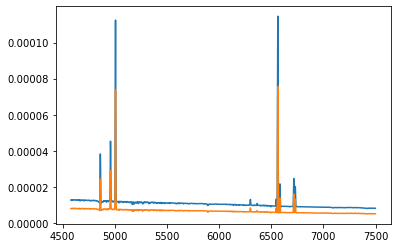

In [10]:
plt.plot(wavearr,galflux)
plt.plot(n,m)


In [11]:
resulte=filteraa('../obs/filters/sdss_r0.par')
wavefilter=resulte[0]
fluxfilter=resulte[1]
vmin=resulte[2]
vmax=resulte[3]
filtereff=resulte[4]
FWHMmin = resulte[5]
FWHMmax = resulte[6]

lambdar=filtereff   #in A

#sky brightness corresponding to this sky magnitude
iskyr0_jy=3631.0*10**(-iskyr0/2.5+3.0)  # sky flux in r in mJy/arcsec^2 unit
iskyr0_nm=iskyr0_jy*3.0/(lambdar/100.0)**2 #sky flux in r in 10^(-12)erg/s/cm^2/A (/arcsec^2 ?)

#readin the ground sky spectrum 
skybg_50=pd.read_csv('../obs/skybg_50_10.dat',sep='\s+',header=None,skiprows=14)
wavesky=np.array(skybg_50[0])*10 #in A
fluxsky1=np.array(skybg_50[1])/10 #phot/s/A/arcsec^2/m^2
fluxsky2=fluxsky1/wavesky*1.98 #change the sky flux unit to 10^(-12)erg/s/cm^2/A/arcsec^2

ii=np.logical_and(wavesky >= vmin, wavesky <= vmax)
wavetmp=wavesky[ii]
fluxtmp=fluxsky1[ii]
             

./../obs/filters/sdss_r0.par


In [12]:
iskyr0_nm

1.13570265230221e-05

In [13]:
targetmag,galtpl,filtera,dlambda,a,b=targetmag,galtpl,filtera,0.98,3490.71,5500

In [14]:
narray=int((b-a)/delta_lambda) 
wavearr=a+delta_lambda*np.float64(np.arange(narray))

In [15]:
# select out the array of r band filter
wavearr1=np.arange(3000,10000,step=dlambda)

ii=np.logical_and(wavearr1 >= vmin, wavearr1 <= vmax)
wavetmp2_r=wavearr1[ii]
x_r=np.interp(wavetmp2_r,wavefilter,fluxfilter)
integratef4_r=x_r*wavetmp2_r   
integconst_r=simps(integratef4_r,wavetmp2_r) # int(lambda*Rlambda*dlambda)

#####################################################################

#define r band sky brightness
x=np.interp(wavetmp,wavefilter,fluxfilter)
vfluxtmp=x*fluxtmp*1.98
skyintegrate=simps( vfluxtmp,wavetmp)
skynorm=iskyr0_nm*integconst_r/skyintegrate 
fluxsky3=np.interp(wavearr1,wavesky,fluxsky2)
fluxsky4=fluxsky3*skynorm
# get the sky spectrum in wavearr grid, the unit should now be the same as fluxvega: 10^(-12) erg/s/A/cm^2  (/arcsec^2 ?)
fluxskypp=np.interp(wavearr,wavearr1,fluxsky4) 

In [16]:
integconst_r

4827973.4700672375

In [17]:
integconst_r

4827973.4700672375

In [19]:
a,b=wavearr_r,fluxsky

NameError: name 'fluxsky' is not defined

In [20]:
#plt.plot(a,b)
plt.plot(wavearr_r,fluxsky)
#plt.xlim(5250,7250)
#plt.plot(wavetmp,fluxtmp)

NameError: name 'fluxsky' is not defined

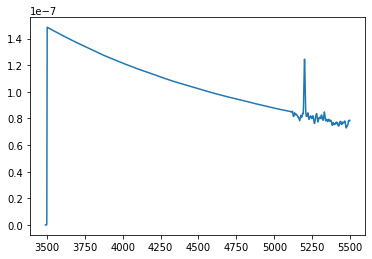

In [105]:
plt.plot(wavearr,fluxskypp)

(0.04, 0.1)

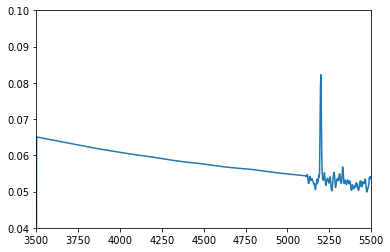

In [123]:
plt.plot(wavesky,fluxsky1)
plt.xlim(3500,5500)
plt.ylim(0.04,0.1)

In [117]:
aaa=np.arange(40*10).reshape(40,10)

In [119]:
aaa

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
       [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
       [ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29],
       [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39],
       [ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49],
       [ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
       [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69],
       [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
       [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89],
       [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99],
       [100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
       [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
       [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
       [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
       [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
       [150, 151, 152, 153, 154, 155, 156, 157, 158, 159],
       [160, 161, 162, 163, 164, 165, 166, 167, 168, 169